In [1]:
# Script to install the required packages for the stock market analysis
#!pip install yfinance
#!pip install pandas
#!pip install matplotlib
#!pip install matplotlib mplfinance
#!pip install seaborn
#!pip install scikit-learn
#!pip install ipywidgets

In [2]:
# set the library
import yfinance as yf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import mplfinance as mpf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display

In [3]:
# List of major tech stocks to analyze
tech_stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "AMD", "INTC", "NFLX"]

In [4]:
# Dictionary to store the data
stocks_data = {}

# Loop through each stock in the list
for ticker in tech_stocks:
    stock = yf.Ticker(ticker)
    data = stock.history(period="10y")
    data['Stock'] = ticker  # Add a new column for the stock name
    # Keep only the date part of the datetime
    data.reset_index(inplace=True)  # Ensure 'Date' is a column, not an index
    data['Date'] = data['Date'].dt.date
    stocks_data[ticker] = data

# Optional: Convert the dictionary to a DataFrame for better visualization
all_stocks_df = pd.concat(stocks_data)
all_stocks_df


Date         Open         High          Low        Close  \
AAPL 0     2015-02-25    29.380988    29.389923    28.619440    28.762369   
     1     2015-02-26    28.762371    29.226893    28.275518    29.126396   
     2     2015-02-27    29.032602    29.159900    28.639546    28.688679   
     3     2015-03-02    28.865102    29.095129    28.652941    28.829369   
     4     2015-03-03    28.800338    28.925401    28.606040    28.889668   
...               ...          ...          ...          ...          ...   
NFLX 2510  2025-02-18  1060.000000  1062.000000  1023.750000  1035.849976   
     2511  2025-02-19  1035.180054  1045.000000  1024.510010  1043.329956   
     2512  2025-02-20  1042.000000  1045.000000  1015.590027  1024.540039   
     2513  2025-02-21  1029.420044  1032.380005   999.390015  1003.150024   
     2514  2025-02-24  1008.000000  1015.150024   984.520020   988.469971   

              Volume  Dividends  Stock Splits Stock  
AAPL 0     298846800        0.0           0.0  AAPL  
     1     365150000        0.0           0.0  AAPL  
     2     248059200        0.0           0.0  AAPL  
     3     192386800        0.0           0.0  AAPL  
     4     151265200        0.0           0.0  AAPL  
...              ...        ...           ...   ...  
NFLX 2510    4229300        0.0           0.0  NFLX  
     2511    2600000        0.0           0.0  NFLX  
     2512    3111800        0.0           0.0  NFLX  
     2513    3731600        0.0           0.0  NFLX  
     2514    4348363        0.0           0.0  NFLX  

[25151 rows x 9 columns]

In [5]:
# Reset the index to separate the date into its own column
all_stocks_df.reset_index(inplace=True)


In [6]:
# Rename 'level_0' to 'Stock'
all_stocks_df.rename(columns={'level_0': 'Stock'}, inplace=True)

# Rearrange columns to have 'Date' and 'Stock' as the first two columns
columns_to_keep = ['Stock', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']
all_stocks_df = all_stocks_df[columns_to_keep]

# Display the first few rows of the DataFrame
print(all_stocks_df.head())

  Stock Stock        Date       Open       High        Low      Close  \
0  AAPL  AAPL  2015-02-25  29.380988  29.389923  28.619440  28.762369   
1  AAPL  AAPL  2015-02-26  28.762371  29.226893  28.275518  29.126396   
2  AAPL  AAPL  2015-02-27  29.032602  29.159900  28.639546  28.688679   
3  AAPL  AAPL  2015-03-02  28.865102  29.095129  28.652941  28.829369   
4  AAPL  AAPL  2015-03-03  28.800338  28.925401  28.606040  28.889668   

      Volume  
0  298846800  
1  365150000  
2  248059200  
3  192386800  
4  151265200  


In [7]:
# Remove duplicate 'Stock' column
all_stocks_df = all_stocks_df.loc[:, ~all_stocks_df.columns.duplicated()]

# Dictionary to store individual stock DataFrames
individual_stock_dfs = {}

# Directory to save the CSV files
output_dir = 'stock_data'
os.makedirs(output_dir, exist_ok=True)

# Loop through each stock and create separate DataFrames
for ticker in tech_stocks:
    individual_stock_dfs[ticker] = all_stocks_df[all_stocks_df['Stock'] == ticker]

    # Save each DataFrame to a CSV file (optional)
    individual_stock_dfs[ticker].to_csv(os.path.join(output_dir, f'{ticker}_stock_data.csv'), index=False)

# Example: Access the DataFrame for Google (GOOGL)
print(individual_stock_dfs['GOOGL'].head())

      Stock        Date       Open       High        Low      Close    Volume
5030  GOOGL  2015-02-25  26.824760  27.379249  26.803336  27.267654  40836000
5031  GOOGL  2015-02-26  27.188440  27.905341  27.156056  27.863493  54032000
5032  GOOGL  2015-02-27  27.806698  28.368164  27.750901  28.029890  68328000
5033  GOOGL  2015-03-02  28.247601  28.695477  28.055796  28.647152  50406000
5034  GOOGL  2015-03-03  28.713409  28.937597  28.421966  28.834970  50526000


In [8]:
# Remove first row of each NVDA stock data
individual_stock_dfs['NVDA'] = individual_stock_dfs['NVDA'].iloc[1:]
NVDAdf = individual_stock_dfs['NVDA']
NVDAdf.count()

Stock     2515
Date      2515
Open      2515
High      2515
Low       2515
Close     2515
Volume    2515
dtype: int64

In [9]:
# Function to calculate investment returns
def calculate_returns(initial_investment, ticker):
    data = individual_stock_dfs[ticker]
    start_price = data.iloc[0]['Close']
    end_price = data.iloc[-1]['Close']
    returns = (end_price / start_price) * initial_investment
    return returns

# Example usage
initial_investment = 1000000  # Example initial investment amount in USD
for ticker in tech_stocks:
    returns = calculate_returns(initial_investment, ticker)
    print(f"If you invested ${initial_investment} in {ticker} 10 years ago, you would have ${returns:.2f} today.")

If you invested $1000000 in AAPL 10 years ago, you would have $8591086.66 today.
If you invested $1000000 in MSFT 10 years ago, you would have $10619640.01 today.
If you invested $1000000 in GOOGL 10 years ago, you would have $6573722.74 today.
If you invested $1000000 in AMZN 10 years ago, you would have $11039261.68 today.
If you invested $1000000 in TSLA 10 years ago, you would have $24332303.28 today.
If you invested $1000000 in NVDA 10 years ago, you would have $244229839.36 today.
If you invested $1000000 in META 10 years ago, you would have $8429891.55 today.
If you invested $1000000 in AMD 10 years ago, you would have $34874194.82 today.
If you invested $1000000 in INTC 10 years ago, you would have $925126.02 today.
If you invested $1000000 in NFLX 10 years ago, you would have $14465515.42 today.


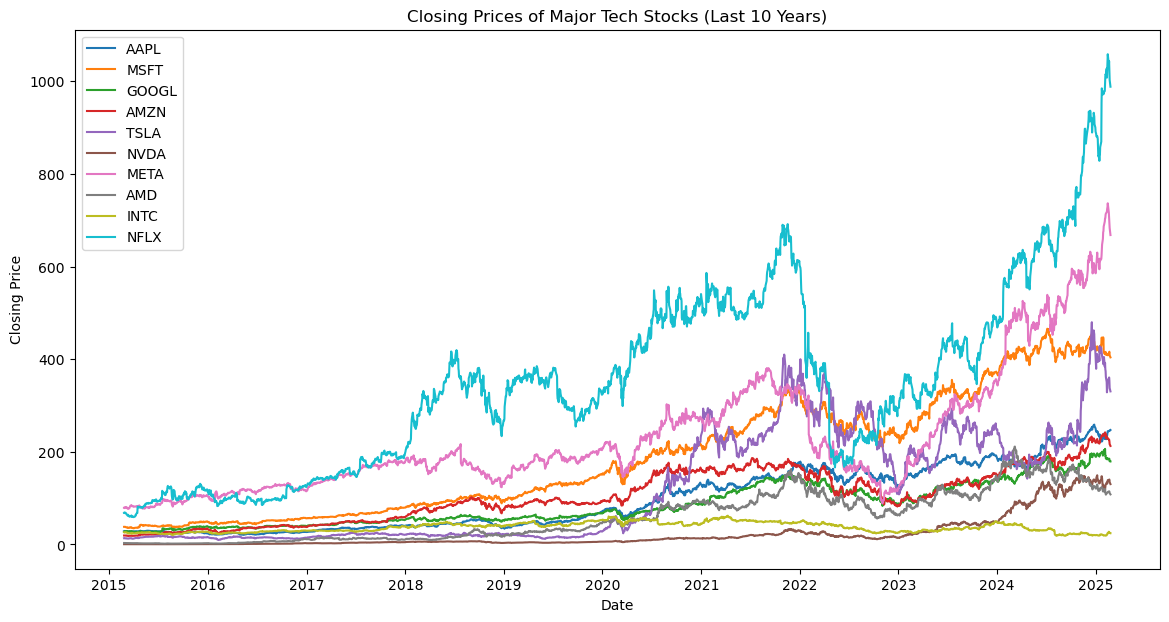

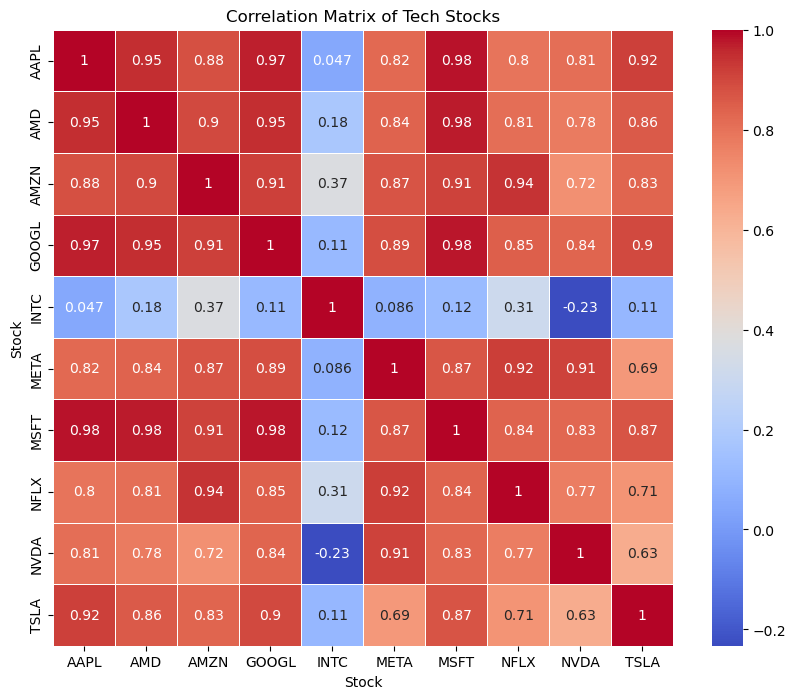

In [10]:
# Calculate summary statistics for each stock
summary_stats = all_stocks_df.groupby('Stock').describe()

# Plot closing prices over time
plt.figure(figsize=(14, 7))
for ticker in tech_stocks:
    plt.plot(individual_stock_dfs[ticker]['Date'], individual_stock_dfs[ticker]['Close'], label=ticker)
plt.title('Closing Prices of Major Tech Stocks (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Plot a correlation matrix
correlation_matrix = all_stocks_df.pivot_table(index='Date', columns='Stock', values='Close').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Tech Stocks')
plt.show()

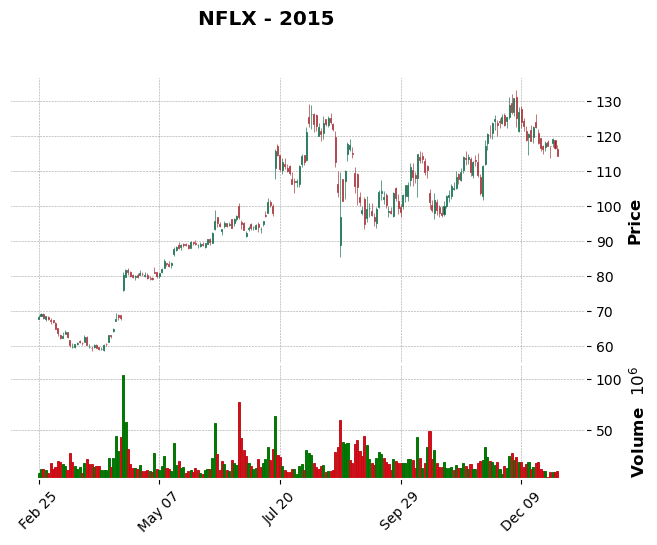

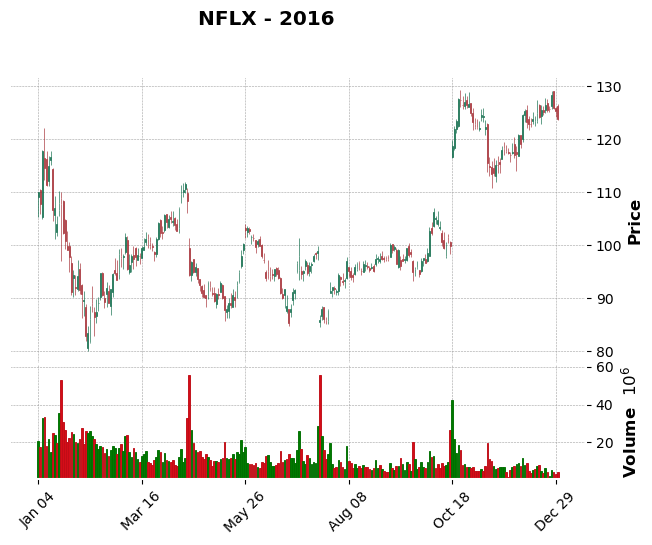

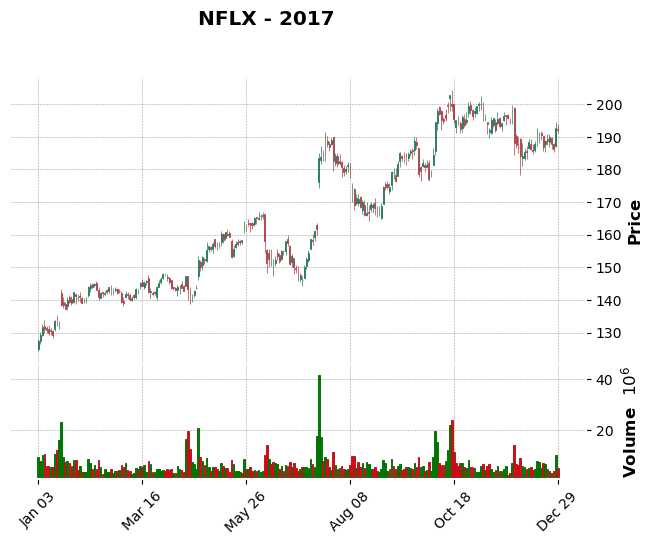

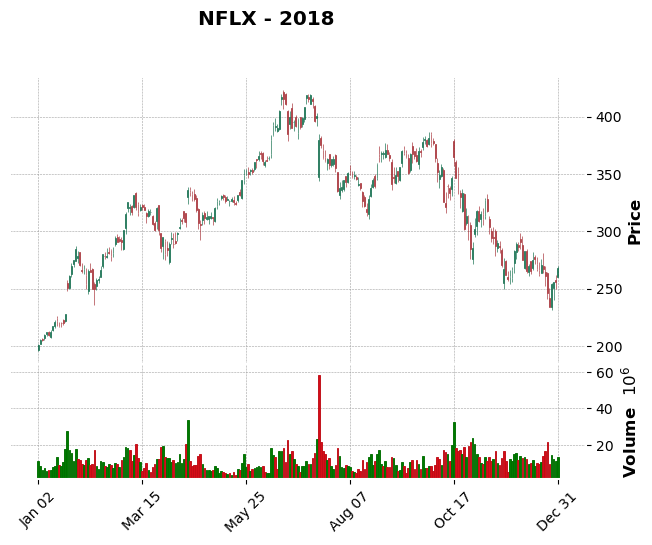

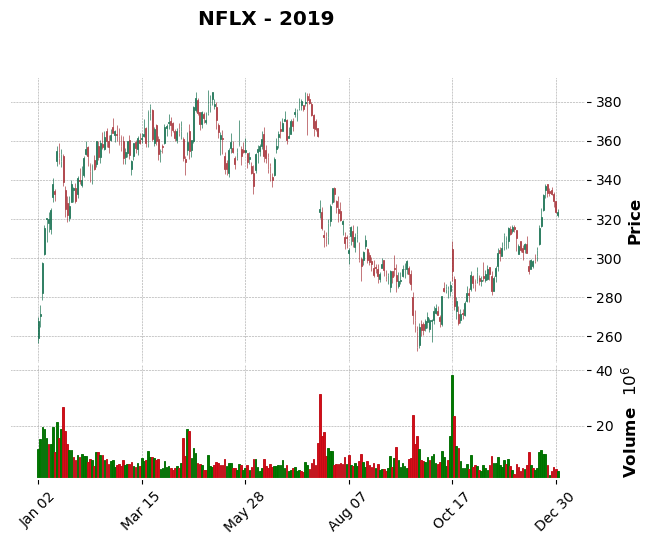

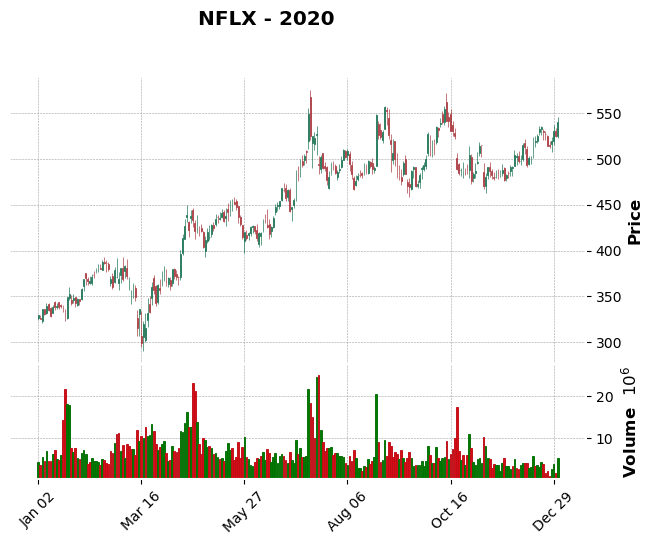

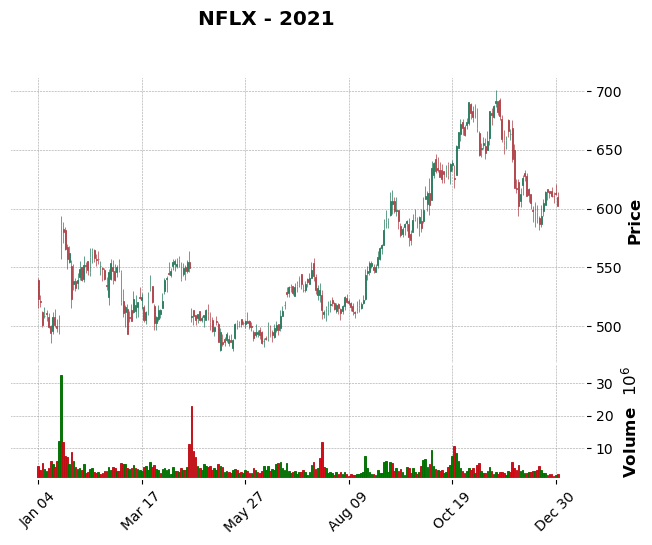

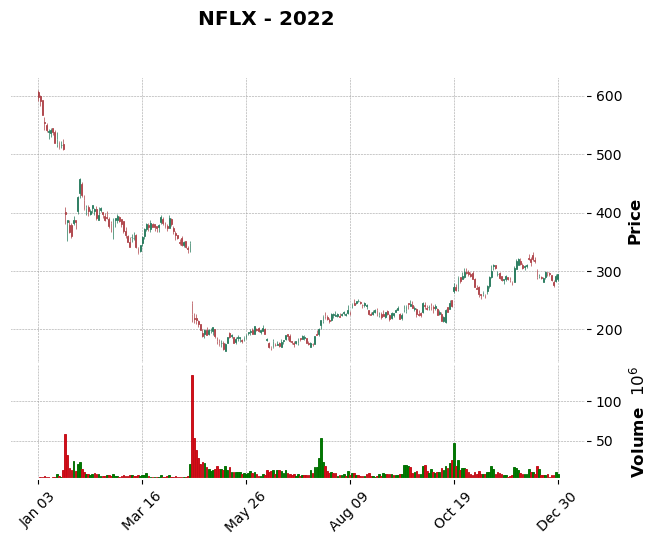

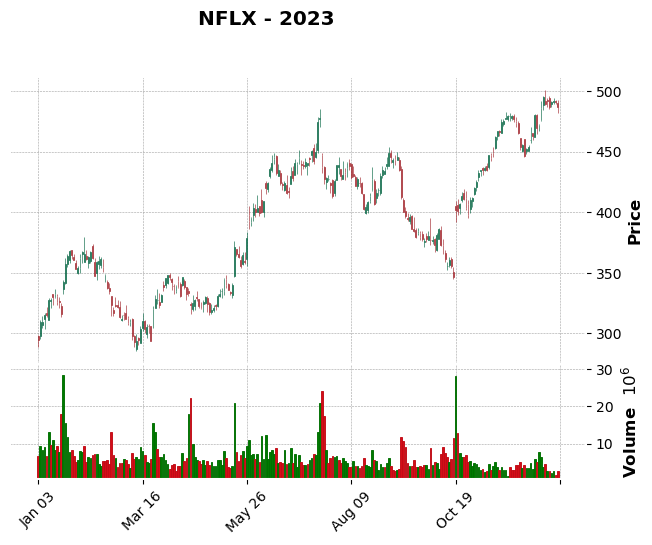

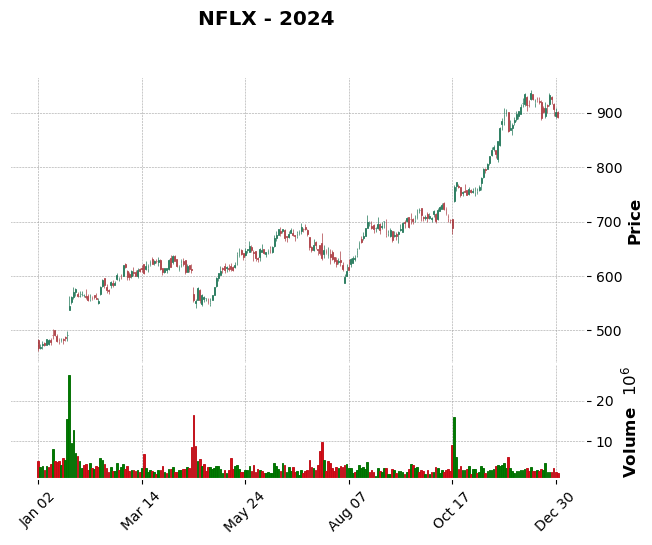

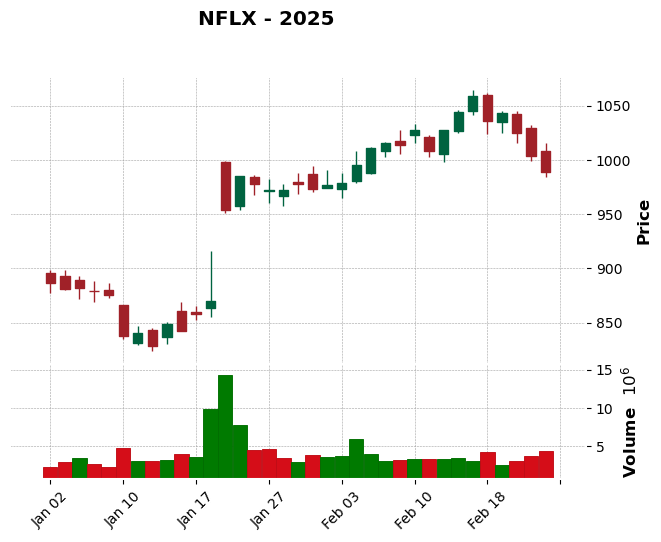

Yearly candlestick charts created and saved for each stock.


In [11]:
# Ensure 'Date' is a datetime type and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot yearly candlestick charts
for year in range(data.index.year.min(), data.index.year.max() + 1):
    yearly_data = data[data.index.year == year]
    if not yearly_data.empty:
        mpf.plot(yearly_data, type='candle', style='charles', title=f"{ticker} - {year}", ylabel='Price', volume=True)
        plt.close()

print("Yearly candlestick charts created and saved for each stock.")

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


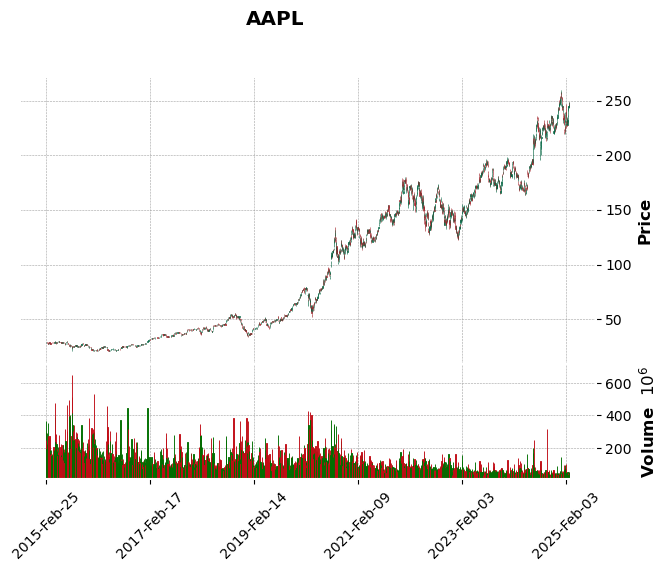

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


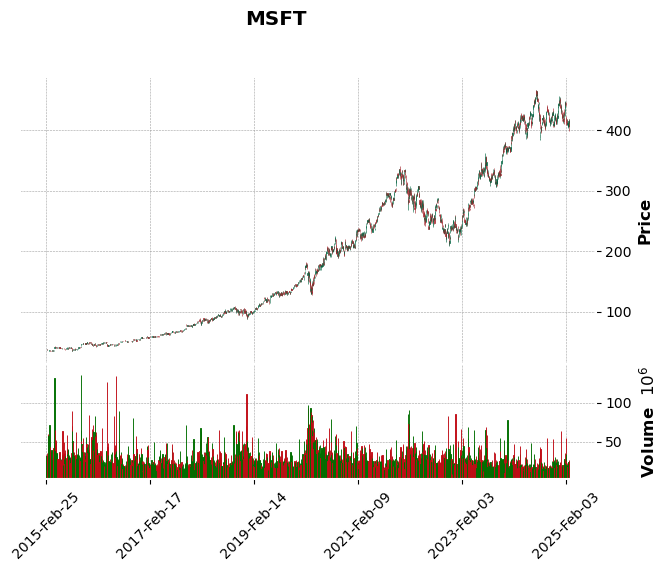

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


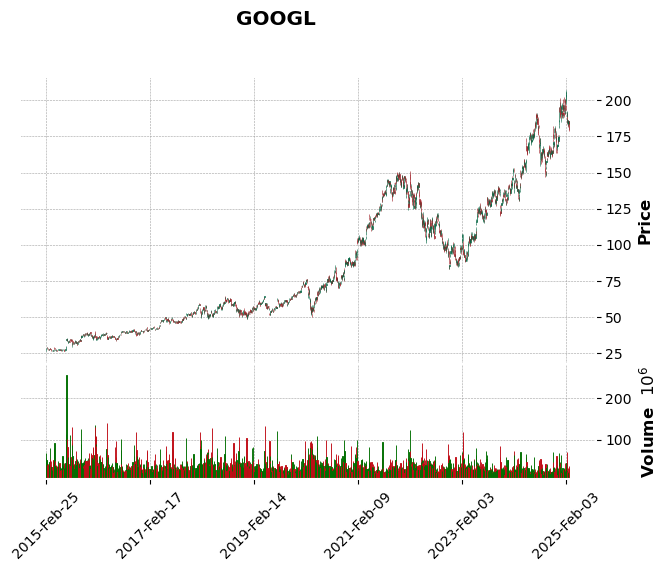

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


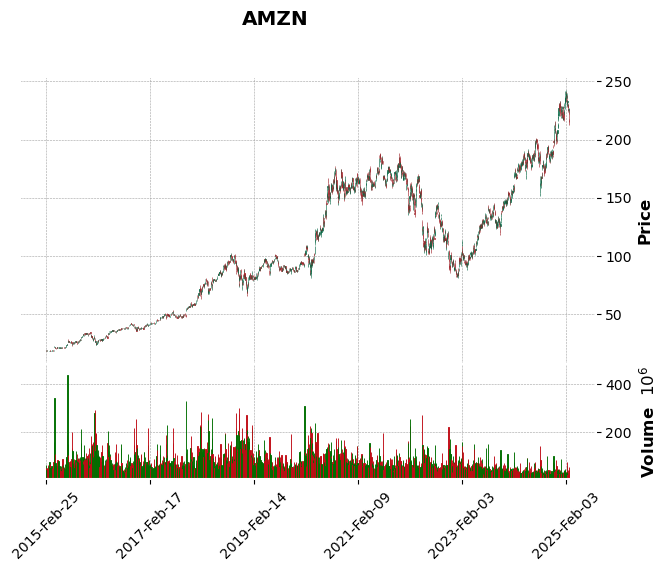

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


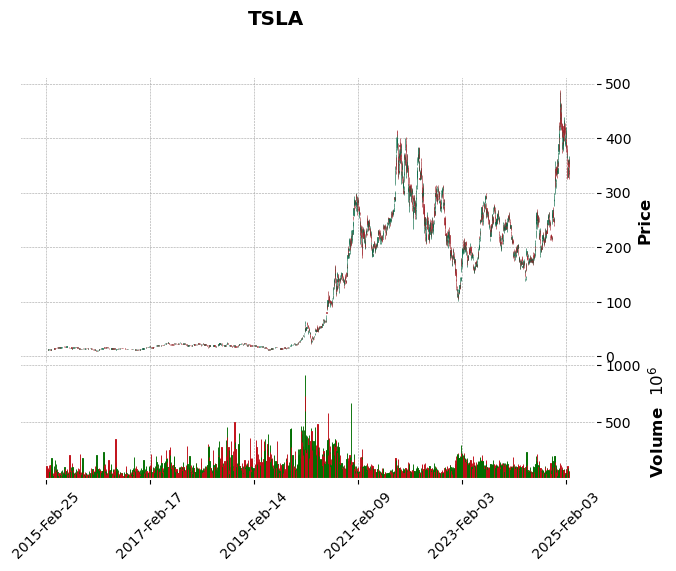

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


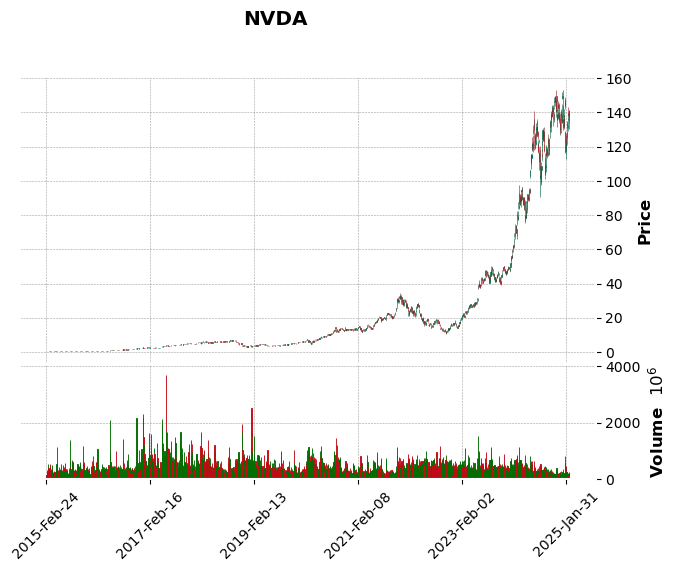

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


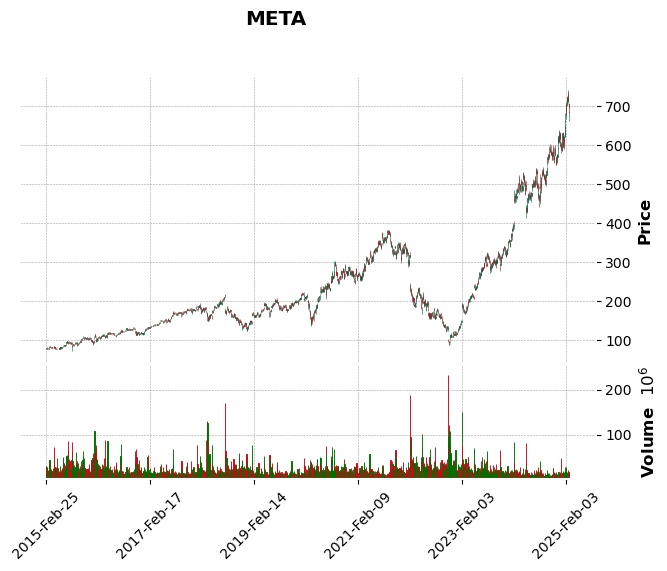

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


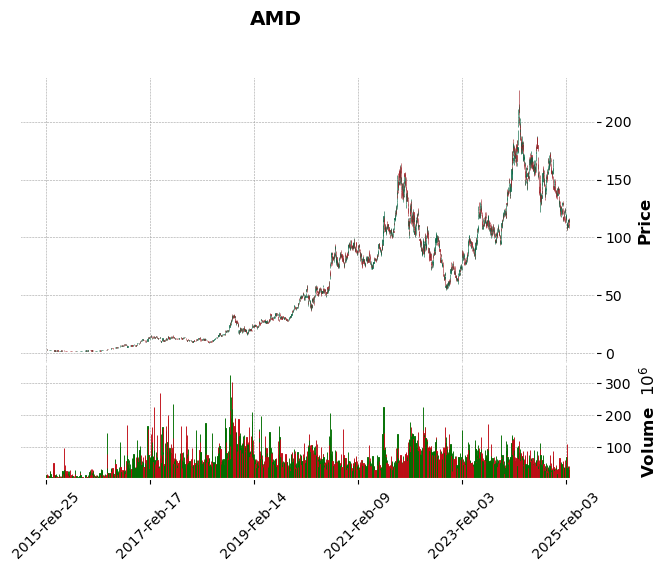

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


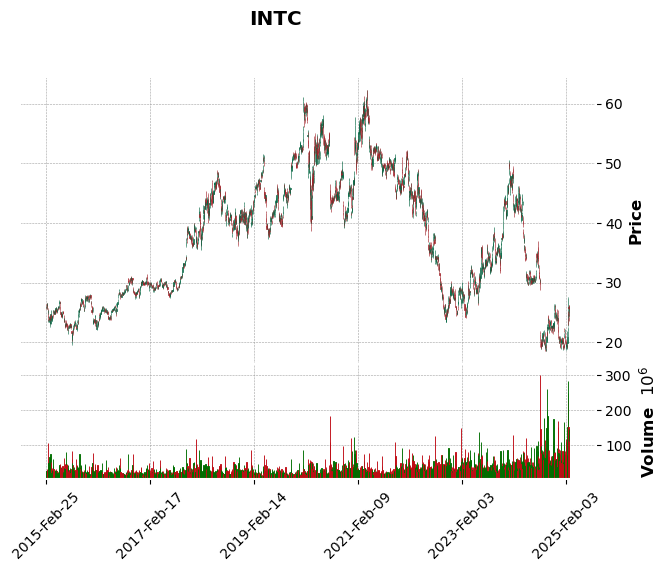

c:\Users\ilknu\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


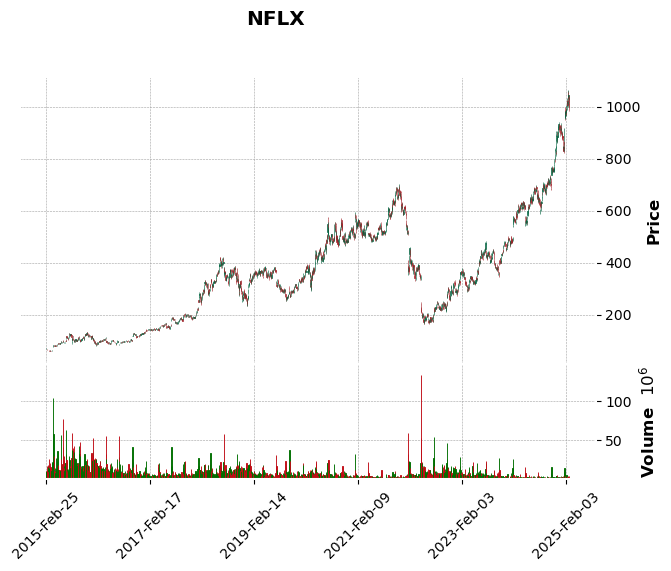

Candlestick charts created and saved for each stock.


In [12]:
# Fetch data from yfinance and create candlestick charts
for ticker in tech_stocks:
    # Fetch historical data
    stock = yf.Ticker(ticker)
    data = stock.history(period="10y")
    
    # Ensure 'Date' is the index
    data.reset_index(inplace=True)
    data.set_index("Date", inplace=True)
    
    # Create the candlestick chart
    mpf.plot(data, type='candle', style='charles', title=ticker, ylabel='Price', volume=True)
    
    # Save the chart as a PNG file
    plt.savefig(f"{ticker}_candlestick_chart.png")
    plt.close()

print("Candlestick charts created and saved for each stock.")




In [13]:
import json
# Define the folder containing stock data CSV files
stock_folder = "stock_data"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(stock_folder) if f.endswith(".csv")]

# Prepare storage dictionaries
stock_data_dict = {}
stock_list = {"stocks": [], "years": []}

In [14]:
# Process each stock file
for file in csv_files:
    stock_name = file.replace("_stock_data.csv", "").upper()  # Extract stock name
    file_path = os.path.join(stock_folder, file)

    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime format
    df['Year'] = df['Date'].dt.year  # Extract year

    # Add stock name to the list
    if stock_name not in stock_list["stocks"]:
        stock_list["stocks"].append(stock_name)

    # Store unique years
    unique_years = df['Year'].unique().tolist()
    stock_list["years"].extend(unique_years)

    # Convert DataFrame to JSON format (nested by year)
    stock_data_dict[stock_name] = {}
    for year in unique_years:
        stock_data_dict[stock_name][str(year)] = df[df['Year'] == year][['Date', 'Close']].to_dict(orient='records')


In [15]:

# Ensure unique and sorted years
stock_list["years"] = sorted(set(stock_list["years"]))

# Convert all 'Date' fields to string format for JSON compatibility
for stock, years_data in stock_data_dict.items():
    for year, records in years_data.items():
        for record in records:
            record["Date"] = pd.to_datetime(record["Date"]).strftime('%Y-%m-%d')  # Fix Timestamp issue

# Save JSON files
with open("stock_data.json", "w") as f:
    json.dump(stock_data_dict, f, indent=4)

with open("stock_list.json", "w") as f:
    json.dump(stock_list, f, indent=4)

print("JSON files created successfully!")

JSON files created successfully!
